In [1]:
# Solving the "gravitational settling in two dimensions" problem in Lautrup p. 182
import numpy as np
import matplotlib.pyplot as plt
from fenics import * 

# Physical constants 
g0     = 9.81
rho    = 917  # such that g0*rho = 1
rhow   = 1029
E, nu  = 2.5*10**9, 0.3
Hw     = 194
# ... convert to Lamé paramenters (Lautrup p. 129)
mu  = E/(2+2*nu)
lam = E*nu/((1+nu)*(1-2*nu))

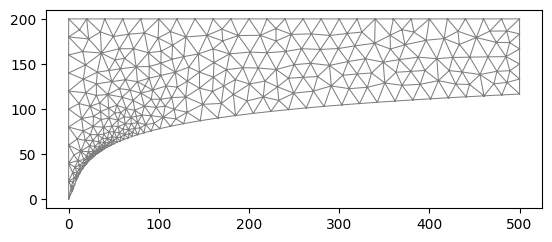

In [2]:
# The 2D mesh
W, H = 1000, 200  # Length, Height (m)
Wres, Hres = 50, 10 # Resolution
#mesh = RectangleMesh(Point(0,0), Point(W,H), Wres, Hres)
mesh = Mesh("calved.xml")
plt.figure()
plot(mesh, lw=0.75); 

In [3]:
# Function space
deg = 1 # Polynomial degree 
V   = VectorFunctionSpace(mesh, 'Lagrange', deg); # Polynomial function space of order "deg" (=1 is linear, ...)
u   = TrialFunction(V) # the unknown function
w   = TestFunction(V)  # the weight function 

# The FEM problem
fvec = rho*Constant((0,-g0)) # Gravity force vector
def eps(u): return sym(grad(u)) # strain tensor (symmetric gradient of displacement field, i.e. 2x2 matrix)
def sig(u): return 2*mu*eps(u) + lam*Identity(2)*tr(eps(u))

n = FacetNormal(mesh)
y = Expression('x[1]',degree =1) # y coordinate
pw = conditional(le(y, Hw), rhow*g0*(Hw -y), 0) # Water pres. field
sigw = -pw*Identity (2) # Water stress tensor for a fluid at rest
F = dot(dot(sigw ,n),w)*ds
a = inner(sig(u), grad(w)) * dx # "inner" is the double dot product
L = dot(fvec,w) * dx + F           # "dot" is the regular (single) dot product 
# Note no boundary terms! w_i=0 where u_i is specified, and we assume no shear stresses which removes the remaining contributions (see slides).

# Define the 4 boundaries
# Note "x = x[0]" is first spatial dimension, and "y = x[1]" is the second spatial dimension
def bot_boundary(x, on_boundary): return on_boundary and near(x[1], 0) 
def top_boundary(x, on_boundary): return on_boundary and near(x[1], H) 
def lft_boundary(x, on_boundary): return on_boundary and near(x[0], 0) 
def rht_boundary(x, on_boundary): return on_boundary and near(x[0], W) 

# Boundary conditions 
bc  = [] # empty list of boundary conditions that we can append (add) to
#bc += [DirichletBC(V.sub(0), Constant(0), lft_boundary)] # u_x = 0 on lft_boundary
#bc += [DirichletBC(V.sub(1), Constant(0), bot_boundary)] # u_y = 0 on bot_boundary
# ... or if no displacement at all on left and bottom boundaries (uncomment below, comment above)
bc += [DirichletBC(V, Constant((0,0)), lft_boundary)] # u = 0 on lft_boundary
#bc += [DirichletBC(V, Constant((0,0)), bot_boundary)] # u = 0 on bot_boundary

# Compute solution
usol = Function(V)       # Define a new function in the space "V" with expansion coefs = 0.
solve(a == L, usol, bc); # Solve the linear FEM problem (Ax=b) for the unknown expansion coef. vector (x) and stored it in "usol".


Solving linear variational problem.


Object cannot be plotted directly, projecting to piecewise linears.
({ A | A_{i_{29}, i_{30}} = I[i_{29}, i_{30}] * (tr(({ A | A_{i_{17}, i_{18}} = 1923076923.076923 * (sym(grad(f_9)))[i_{17}, i_{18}] }) + ({ A | A_{i_{21}, i_{22}} = ({ A | A_{i_{19}, i_{20}} = 1442307692.3076923 * I[i_{19}, i_{20}] })[i_{21}, i_{22}] * (tr(sym(grad(f_9)))) }))) / 2 }) + ({ A | A_{i_{23}, i_{24}} = 1923076923.076923 * (sym(grad(f_9)))[i_{23}, i_{24}] }) + ({ A | A_{i_{27}, i_{28}} = ({ A | A_{i_{25}, i_{26}} = 1442307692.3076923 * I[i_{25}, i_{26}] })[i_{27}, i_{28}] * (tr(sym(grad(f_9)))) })
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


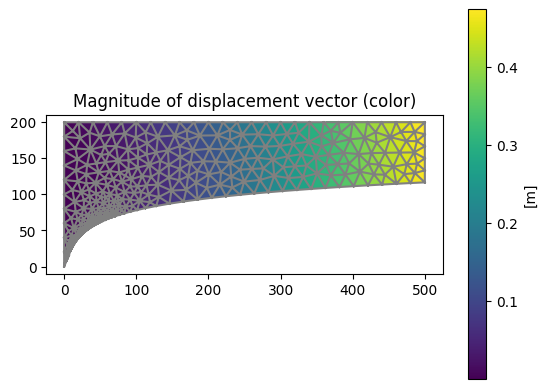

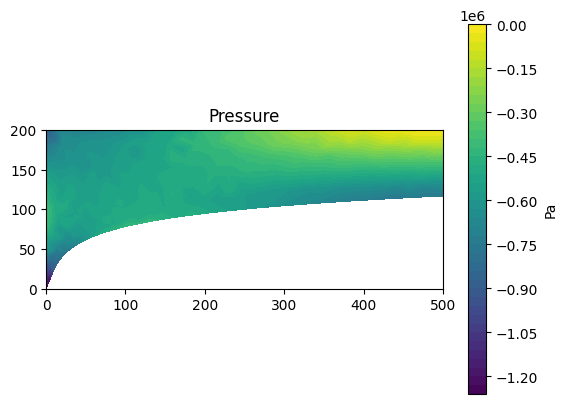

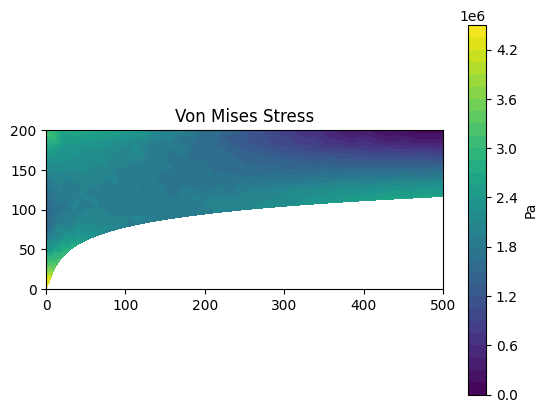

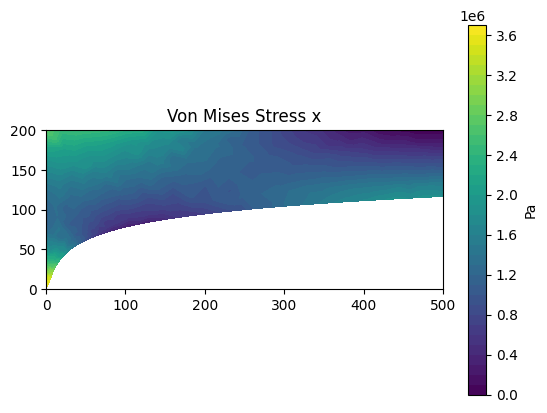

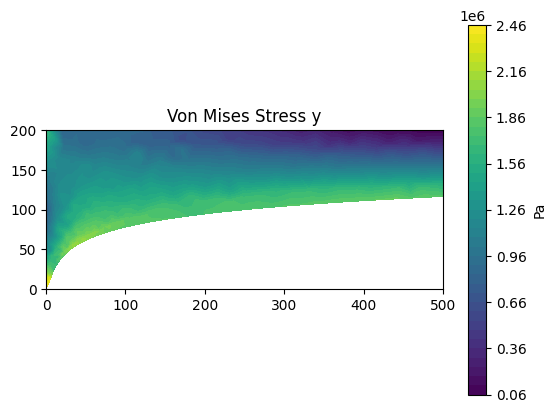

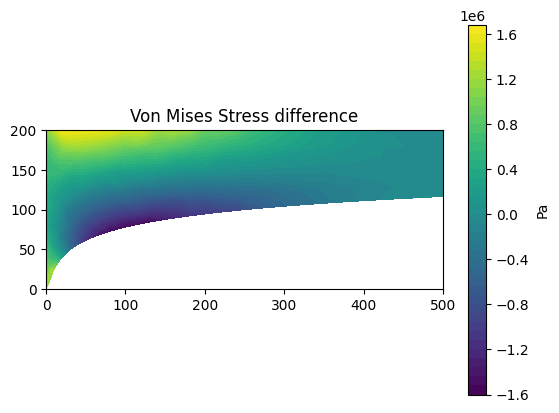

In [4]:
plt.figure()
h = plot(usol, mode='displacement', title='Magnitude of displacement vector (color)'); # Plot solution
plot(mesh); 
plt.colorbar(h,label='[m]');

# Calculate pressure field
plt.figure()
p = tr(sig(usol))/2 # mean normal stress
h = plot(p, title='Pressure');
plt.colorbar(h,label='Pa');

plt.figure()
tau = sig(usol) + p*Identity(2)
print(tau)
vonmises = sqrt(inner(tau,tau)*3/2)
vm = plot(vonmises, title='Von Mises Stress')
plt.colorbar(vm, label='Pa')

plt.figure()
taux = dot(dot(tau,Constant((1,0))),Constant((1,0)))
vonmisesx = sqrt(inner(taux,taux)*3/2)
vmx = plot(vonmisesx, title='Von Mises Stress x')
plt.colorbar(vmx, label='Pa')

plt.figure()
tauy = dot(dot(tau,Constant((0,1))),Constant((0,1)))
vonmisesy = sqrt(inner(tauy,tauy)*3/2)
vmy = plot(vonmisesy, title='Von Mises Stress y')
plt.colorbar(vmy, label='Pa')

plt.figure()
vonmisesdif = vonmisesx-vonmisesy
vmdif = plot(vonmisesdif, title='Von Mises Stress difference')
plt.colorbar(vmdif, label='Pa')

In [5]:
# Potential energy contributions (elastic and gravitational) (see p. 136)
U_ela = assemble( 0.5*inner(sig(usol),eps(usol)) * dx ) # Integral over the elastic energy density
dU_pot = assemble( -dot(fvec,usol) * dx )               # Integral over the change in grav. potential energy density
print('U_ela =', U_ela)
print('dU_pot =', dU_pot)

U_ela = 5020293.035245761
dU_pot = 79161198.44913788
